# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных

# Признаки:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

# Целевой признак:

- Price — цена (евро)

## Подготовка данных

### Загрузка данных:

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import warnings

import lightgbm as lgb
from random import randint
from tqdm import tqdm_notebook
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor

In [2]:
!pip install scikit-learn==1.4.0

In [3]:
warnings.filterwarnings('ignore')

In [4]:
autos = pd.read_csv('/datasets/autos.csv')

In [5]:
display(autos.head(10))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [6]:
print(autos.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Подготовка данных:

#### Пропуски по столбцам:

In [7]:
na_counts = autos.isna().sum()
print(na_counts)

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


#### Пропуски по столбцам в процентах:

In [8]:
na_percentage = (autos.isna().mean() * 100).round(2)
print(na_percentage)

DateCrawled           0.00
Price                 0.00
VehicleType          10.58
RegistrationYear      0.00
Gearbox               5.60
Power                 0.00
Model                 5.56
Kilometer             0.00
RegistrationMonth     0.00
FuelType              9.28
Brand                 0.00
Repaired             20.08
DateCreated           0.00
NumberOfPictures      0.00
PostalCode            0.00
LastSeen              0.00
dtype: float64


#### Суммарное количество дубликатов:

In [9]:
print(sum(autos.duplicated()))

4


#### Удалим дубликаты:

In [10]:
autos = autos.drop_duplicates()

In [11]:
autos.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


### Удалим ненужные для модели признаки:

In [12]:
df = autos.drop(['DateCrawled',
                 'RegistrationMonth',
                 'DateCreated', 
                 'NumberOfPictures',
                 'PostalCode',
                 'LastSeen'],
                axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354365 non-null  int64 
 1   VehicleType       316875 non-null  object
 2   RegistrationYear  354365 non-null  int64 
 3   Gearbox           334532 non-null  object
 4   Power             354365 non-null  int64 
 5   Model             334660 non-null  object
 6   Kilometer         354365 non-null  int64 
 7   FuelType          321470 non-null  object
 8   Brand             354365 non-null  object
 9   Repaired          283211 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


### Продолжим предобработку:

#### Проверим дубликаты:

In [13]:
df.duplicated().sum()

45036

#### Удалим дубликаты:

In [14]:
df = df.drop_duplicates()

###### Промежуточные выводы:
Необходимо:
1. Исправить некорректные значения в исходных данных:
- В столбце Price минимальная цена 0
- В столбце RegistrationYear есть неадекватно большие даты регистрации
- В столбце Power есть нулевые и неадекватно большие значения мощности двигателя
- В столбце RegistrationMonth есть нулевые значения

2. Заполнить пропуски:
- В VehicleType, Model и FuelType заменить пропущенные значения на 'unknown'
- Из-за того, что значения в Gearbox и Repared бинарные - заполнить пропуски можно, если для Gearbox считать стандартным значением 'manual', а для Repared взять значение 'no' при отсутствии других данных

3. Прочее: 
- В столбце Kilometer около половины значений пробега равны 150000, что странно и может быть связано с максимальной доступной опцией в заявке по типу "150000 и более", но это не должно нам мешать

### Заполним пропуски:

#### В VehicleType, Model и FuelType заменить пропущенные значения на 'unknown':

In [15]:
df['VehicleType'] = df['VehicleType'].fillna('unknown')
df['Model'] = df['Model'].fillna('unknown')
df['FuelType'] = df['FuelType'].fillna('unknown')

#### В Gearbox и Repaired заменить пропущенные значения на 'manual' и 'no':

In [16]:
df['Gearbox'] = df['Gearbox'].fillna('manual')
df['Repaired'] = df['Repaired'].fillna('no')

#### Проверим результат:

In [17]:
print(df.isna().sum())

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64


Пропуски обработаны, идём дальше

### Проанализируем всякого рода необычные значения в текущей версии датафрейма:

In [18]:
df.describe()

,Price,RegistrationYear,Power,Kilometer
count,309329.000000,309329.000000,309329.000000,309329.000000
mean,4486.937196,2004.360105,110.976908,127217.735809
std,4564.852796,92.541399,200.969473,38532.941010
min,0.000000,1000.000000,0.000000,5000.000000
25%,1100.000000,1999.000000,69.000000,125000.000000
50%,2800.000000,2003.000000,105.000000,150000.000000
75%,6500.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


#### Исправим значения в столбце Price:

##### Построим график цен:

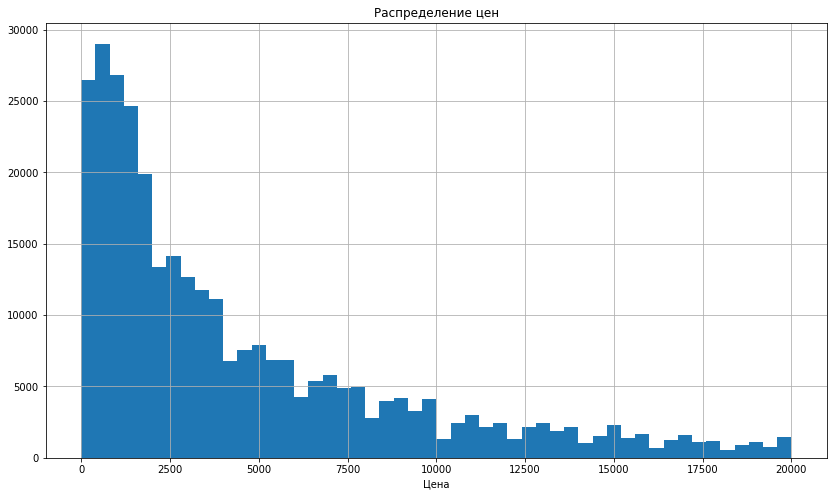

In [19]:
df['Price'].hist(bins=50, figsize=(14, 8))

plt.title('Распределение цен')
plt.xlabel('Цена')
plt.show()

##### Боксплот для проверки выбросов:

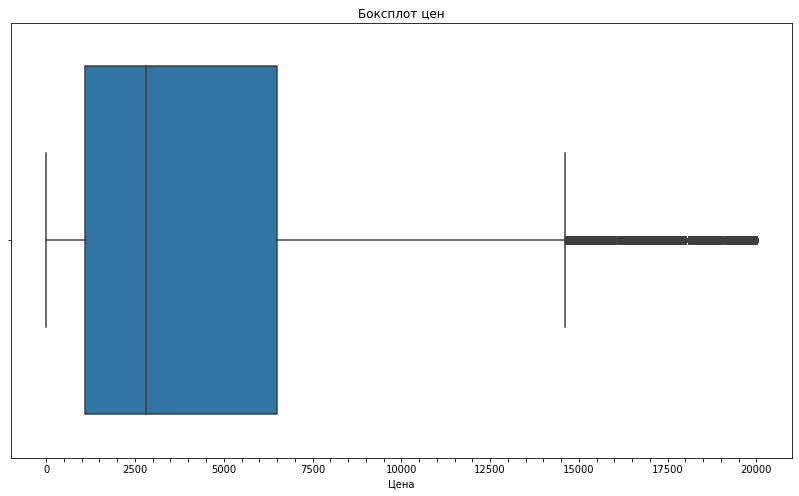

In [20]:
plt.figure(figsize=(14, 8))
sns.boxplot(x=df['Price'])

plt.title('Боксплот цен')
plt.xlabel('Цена')

# Определите минимальное и максимальное значение на оси X
xmin, xmax = df['Price'].min(), df['Price'].max()

# Создайте диапазон значений с шагом 500
x_ticks = range(int(xmin), int(xmax) + 500, 500)

# Создайте диапазон значений с шагом 2500 для числовых меток
x_labels = [str(tick) if tick % 2500 == 0 else '' for tick in x_ticks]

# Установите метки оси X
plt.xticks(x_ticks, x_labels)

plt.show()

In [21]:
df['Price'].value_counts()

0        8904
500      4650
1500     4533
1000     3875
1200     3799
         ... 
1654        1
5748        1
7285        1
11379       1
8188        1
Name: Price, Length: 3731, dtype: int64

#### Удалим нулевые значения:

In [22]:
df = df.query('Price > 0')
df['Price'].describe()

count    300425.000000
mean       4619.921098
std        4565.205287
min           1.000000
25%        1200.000000
50%        2900.000000
75%        6650.000000
max       20000.000000
Name: Price, dtype: float64

###### Несмотря на удаление очевидно нерелевантных нулевых значений, минимальная цена в 1 евро не выглядит реальной, даже если кто-то и продавал машину за символическую плату, чтобы от неё избавиться

#### Исходя из графика(боксплота, который показывает, что минимальная реальная цена находится в районе ~1000, пройдемся по диапазону цен, чтобы выбрать нижние и верхние границы:

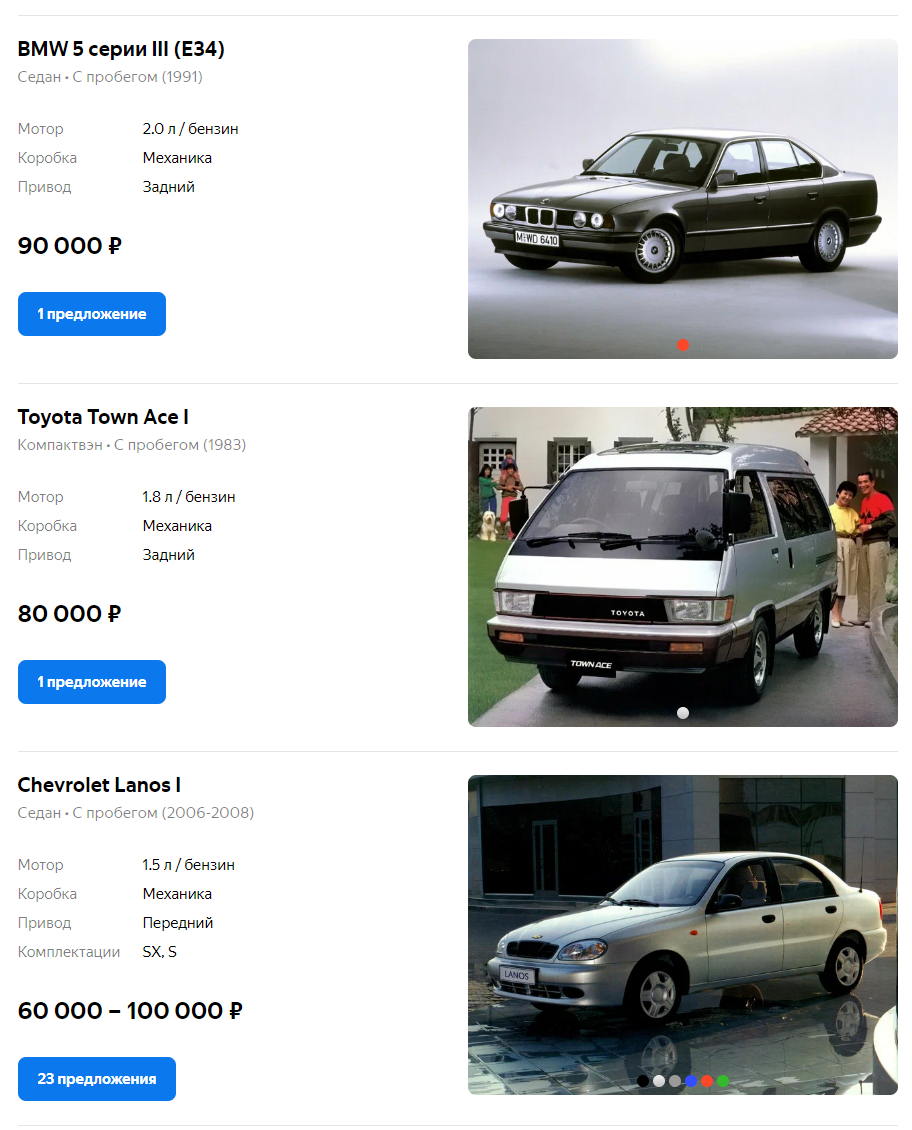

###### Цена от ~1000 евро выглядит адекватной если сравнить с самыми дешевыми вариантами на рынке, так что используем её в качестве нижней границы

In [23]:
# Вывод топ-10 строк по максимальной стоимости
top_10_expensive = df.nlargest(10, 'Price')

print(top_10_expensive)

       Price  VehicleType  RegistrationYear Gearbox  Power     Model  \
1515   20000        sedan              2010    auto    239        a6   
1586   20000        sedan              2014    auto    184      leon   
2128   20000        sedan              2014  manual    135      ceed   
3728   20000        sedan              2011    auto    265  c_klasse   
6286   20000        sedan              2009    auto    272  e_klasse   
6863   20000        coupe              2002  manual      0   unknown   
8441   20000        wagon              2010  manual    204       3er   
8679   20000          suv              1975  manual     44     other   
9335   20000        coupe              2009  manual    179        a5   
10153  20000  convertible              2006  manual    265   z_reihe   

       Kilometer  FuelType           Brand Repaired  
1515      150000  gasoline            audi       no  
1586       40000  gasoline            seat       no  
2128       30000    petrol             kia   

Топ-10 по цене вывел, и большая часть - действительно дорогие авто, и моих знаний не хватает, чтобы сказать, если там есть примеры с странно завышенной ценой, так что я просто уберу потолок цены - будем считать, что это не выбросы, а просто редкие значения штучных предложений по продаже дорогих машин

In [24]:
df = df.query('1000 <= Price')

#### Исправим значения в столбце Power:

In [25]:
df['Power'].describe()

count    237096.000000
mean        122.115308
std         203.768813
min           0.000000
25%          77.000000
50%         116.000000
75%         150.000000
max       20000.000000
Name: Power, dtype: float64

count    217937.000000
mean        128.303675
std          54.142234
min           1.000000
25%          90.000000
50%         120.000000
75%         151.000000
max         490.000000
Name: Power, dtype: float64

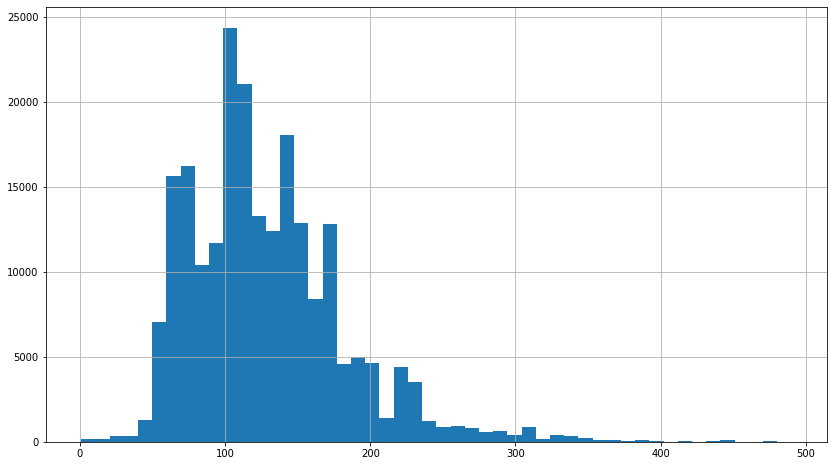

In [26]:
df = df.query(('0 < Power < 500'))
df['Power'].hist(bins=50, figsize=(14, 8))
df['Power'].describe()

По графику видно, что значения выше ~ 450 уже не встречаются, так что оставим всё до ~450

In [27]:
df = df[df['Power'] <= 450]
df['Power'] = df['Power'].replace(0, np.NaN).fillna(df.groupby('Model')['Power'].transform(lambda x: x.median() 
                                                                                           if x.median() else np.nan))

#### Исправим значения в столбце RegistrationYear:

In [28]:
df['RegistrationYear'].describe()

count    217903.000000
mean       2004.471256
std          29.289013
min        1000.000000
25%        2001.000000
50%        2005.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

#### Возьмем необходимую информацию из первоначального датафрейма autos, так как нужные для этого столбцы мы из рабочей версии df выкинули:

In [29]:
date_recent = pd.to_datetime(autos['DateCreated'])
date_recent.max()

Timestamp('2016-04-07 00:00:00')

In [30]:
date_past = pd.to_datetime(autos['RegistrationYear'])
date_past.min()

Timestamp('1970-01-01 00:00:00.000001')

#### Назначим нижнюю и верхнюю границы релевантных значений:

In [31]:
df = df[(df['RegistrationYear'] > 1970) & (df['RegistrationYear'] < 2017)]
df['RegistrationYear'].describe()

count    209434.000000
mean       2003.963750
std           6.061941
min        1971.000000
25%        2001.000000
50%        2005.000000
75%        2008.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

#### Посмотрим на получившийся датафрейм:

In [32]:
df.describe()

,Price,RegistrationYear,Power,Kilometer
count,209434.000000,209434.000000,209434.000000,209434.000000
mean,5897.731395,2003.963750,128.783130,124661.946007
std,4615.776049,6.061941,53.881963,38524.043300
min,1000.000000,1971.000000,1.000000,5000.000000
25%,2250.000000,2001.000000,90.000000,100000.000000
50%,4300.000000,2005.000000,120.000000,150000.000000
75%,8290.000000,2008.000000,155.000000,150000.000000
max,20000.000000,2016.000000,450.000000,150000.000000


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209434 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             209434 non-null  int64 
 1   VehicleType       209434 non-null  object
 2   RegistrationYear  209434 non-null  int64 
 3   Gearbox           209434 non-null  object
 4   Power             209434 non-null  int64 
 5   Model             209434 non-null  object
 6   Kilometer         209434 non-null  int64 
 7   FuelType          209434 non-null  object
 8   Brand             209434 non-null  object
 9   Repaired          209434 non-null  object
dtypes: int64(4), object(6)
memory usage: 17.6+ MB


###### Промежуточные выводы:
- Оставили автомобили c годом регистрации 1970-2016.
- Удалили нулевые значения в колонке price
- Установили ограничение мощности до 450
- Заменили нулевые значения мощности на медианное значение для каждой модели

# Выводы:
- Изучены данные
- Удалены дубликаты
- Убраны ненужные для модели признаки
- Обработаны пропущенные значения
- Обработаны некорректные данные

Можно переходить к обучению моделей с использованием датафрейма df

## Обучение моделей

### Подготовка:

In [34]:
RANDOM_STATE = 42

In [35]:
# Определение целевого признака и признаков
X = df.drop('Price', axis=1)
y = df['Price']

# Разделение данных на обучающие, тестовые и валидационные выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE)

# Определение категориальных признаков
categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

# Создание трансформера для кодирования категориальных признаков и масштабирования числовых признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features),
        ('num', StandardScaler(), [col for col in X.columns if col not in categorical_features])
    ],
    remainder='passthrough'  # Оставить остальные колонки без изменений
)

# Применение трансформера на обучающих данных
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

# Преобразование разреженных матриц в плотные массивы
X_train = X_train.toarray()
X_val = X_val.toarray()
X_test = X_test.toarray()


# Вывод информации для проверки
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (134037, 308)
Shape of X_val: (33510, 308)
Shape of X_test: (41887, 308)


### Обучение моделей:

#### Обучение модели LGBM:

In [36]:
# Определение параметров модели LightGBM
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'verbose': -1,
    'n_jobs': -1
}

# Создание модели LightGBM
model_lgb = lgb.LGBMRegressor(**params)

# Кросс-валидация для выбора лучшей модели
start_time = time.time()
cv_results = cross_val_score(
    model_lgb,
    X_train,
    y_train,
    cv=5,
    scoring='neg_root_mean_squared_error'
)
end_time = time.time()

# Время обучения на кросс-валидации
training_time_cv = end_time - start_time

# Обучение модели на всех обучающих данных
start_time = time.time()
model_lgb.fit(X_train, y_train)
end_time = time.time()

# Время обучения финальной модели
training_time_lgb = end_time - start_time

# Время предсказания
start_time = time.time()
y_pred_lgb = model_lgb.predict(X_val)
end_time = time.time()
prediction_time_lgb = end_time - start_time

# Оценка качества модели на валидационной выборке
rmse_lgb = mean_squared_error(y_val, y_pred_lgb, squared=False)

print("Время обучения, сек(кросс-валидация):", training_time_cv)
print("Время обучения, сек(финальная модель):", training_time_lgb)
print("Время предсказания, сек:", prediction_time_lgb)
print("RMSE на валидационной выборке:", rmse_lgb)

Время обучения, сек(кросс-валидация): 20.04882550239563
Время обучения, сек(финальная модель): 4.301113128662109
Время предсказания, сек: 0.3057701587677002
RMSE на валидационной выборке: 1748.7643857734472


#### Обучение модели CatBoost:

In [37]:
model_catboost = CatBoostRegressor(
    iterations=50,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    random_state=RANDOM_STATE,
    verbose=0
)

# Кросс-валидация для выбора лучшей модели
start_time = time.time()
cv_results = cross_val_score(
    model_catboost, 
    X_train, 
    y_train, 
    cv=5, 
    scoring='neg_root_mean_squared_error'
)

end_time = time.time()

# Время обучения на кросс-валидации
training_time_cv = end_time - start_time

# Обучение модели на всех обучающих данных
start_time = time.time()
model_catboost.fit(X_train, y_train)
end_time = time.time()

# Время обучения финальной модели
training_time_catboost = end_time - start_time

# Время предсказания
start_time = time.time()
y_pred_catboost = model_catboost.predict(X_val)
end_time = time.time()
prediction_time_catboost = end_time - start_time

# Оценка качества модели на валидационной выборке
rmse_catboost = mean_squared_error(y_val, y_pred_catboost, squared=False)

print("Время обучения, сек(кросс-валидация):", training_time_cv)
print("Время обучения, сек(финальная модель):", training_time_catboost)
print("Время предсказания, сек:", prediction_time_catboost)
print("RMSE на валидационной выборке:", rmse_catboost)

Время обучения, сек(кросс-валидация): 44.58867835998535
Время обучения, сек(финальная модель): 8.995729684829712
Время предсказания, сек: 1.7541592121124268
RMSE на валидационной выборке: 1996.0925042037654


#### Обучение модели XGB:

Скрыл выполение из-за долгого обучения на серверах яндекса(1800сек)

#### Обучение модели LinearRegression:

In [38]:
X = df.drop('Price', axis=1)
y = df['Price']

# Разделение данных на обучающие, тестовые и валидационные выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE)

# Определение категориальных признаков
categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

# Создание трансформера для кодирования категориальных признаков и масштабирования числовых признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), [col for col in X.columns if col not in categorical_features])
    ]
)

# Создание пайплайна с предобработкой (включая масштабирование) и моделью LinearRegression
model_linear_regression = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])


# Кросс-валидация для выбора лучшей модели
start_time = time.time()
cv_results = cross_val_score(model_linear_regression,
                             X_train,
                             y_train,
                             cv=5,
                             scoring='neg_root_mean_squared_error')
end_time = time.time()

# Время обучения на кросс-валидации
training_time_cv = end_time - start_time

# Обучение модели на всех обучающих данных
start_time = time.time()
model_linear_regression.fit(X_train, y_train)
end_time = time.time()

# Время обучения финальной модели
training_time_lr = end_time - start_time

# Время предсказания
start_time = time.time()
y_pred_lr = model_linear_regression.predict(X_test)
end_time = time.time()
prediction_time_lr = end_time - start_time

# Оценка качества модели на тестовом наборе
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)

print("Время обучения, сек(кросс-валидация):", training_time_cv)
print("Время обучения, сек(финальная модель):", training_time_lr)
print("Время предсказания, сек:", prediction_time_lr)
print("RMSE на тестовом наборе:", rmse_lr)

Время обучения, сек(кросс-валидация): 49.7005569934845
Время обучения, сек(финальная модель): 12.886346340179443
Время предсказания, сек: 0.23056769371032715
RMSE на тестовом наборе: 2609.1850756917547


## Анализ моделей

### Составление таблицы результатов работы моделей

In [42]:
# Создание DataFrame с результатами
results = pd.DataFrame({
    'Модель': ['Linear Regression', 'LGBM', 'CatBoost'],
    'Training Time (sec)': [training_time_lr, training_time_lgb, training_time_catboost],
    'Prediction Time (sec)': [prediction_time_lr, prediction_time_lgb, prediction_time_catboost],
    'Метрика RMSE': [rmse_lr, rmse_lgb, rmse_catboost]
})

# Округление значений до целого числа
results['Метрика RMSE'] = results['Метрика RMSE'].round(0).astype(int)
results['Training Time (sec)'] = results['Training Time (sec)'].round(2)
results['Prediction Time (sec)'] = results['Prediction Time (sec)'].round(2)

# Сортировка по возрастанию значений в столбце 'Метрика RMSE'
results = results.sort_values(by='Метрика RMSE', ascending=True)

# Сброс индекса и удаление старого индекса
results.reset_index(drop=True, inplace=True)

# Вывод DataFrame
results

,Модель,Training Time (sec),Prediction Time (sec),Метрика RMSE
0,LGBM,4.30,0.31,1749
1,CatBoost,9.00,1.75,1996
2,Linear Regression,12.89,0.23,2609


In [44]:
# Создание и обучение модели DummyRegressor
dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(X_train, y_train)

# Предсказание на валидационной выборке
y_pred_dummy = dummy_regressor.predict(X_val)

# Вычисление RMSE для DummyRegressor
rmse_dummy = mean_squared_error(y_val, y_pred_dummy, squared=False)
print(f"RMSE для DummyRegressor на валидационной выборке: {rmse_dummy:.0f}")

# Добавление результата DummyRegressor в таблицу результатов
results = pd.DataFrame({
    'Модель': ['Dummy Regressor', 'Linear Regression', 'LGBM', 'CatBoost'],
    'Training Time (sec)': [0, training_time_lr, training_time_lgb, training_time_catboost],
    'Prediction Time (sec)': [0, prediction_time_lr, prediction_time_lgb, prediction_time_catboost],
    'Метрика RMSE': [rmse_dummy, rmse_lr, rmse_lgb, rmse_catboost]
})

# Округление значений до целого числа
results['Метрика RMSE'] = results['Метрика RMSE'].round(0).astype(int)
results['Training Time (sec)'] = results['Training Time (sec)'].round(2)
results['Prediction Time (sec)'] = results['Prediction Time (sec)'].round(2)

# Сортировка по возрастанию значений в столбце 'Метрика RMSE'
results = results.sort_values(by='Метрика RMSE', ascending=True)

# Сброс индекса и удаление старого индекса
results.reset_index(drop=True, inplace=True)

# Вывод DataFrame
results

RMSE для DummyRegressor на валидационной выборке: 4619


,Модель,Training Time (sec),Prediction Time (sec),Метрика RMSE
0,LGBM,4.30,0.31,1749
1,CatBoost,9.00,1.75,1996
2,Linear Regression,12.89,0.23,2609
3,Dummy Regressor,0.00,0.00,4619


Лучшая модель градиентного бустинга LGBM валидационной выборке демонстрирует лучшее соотношение скорости выполнения и минимизации значения метрики RMSE, при этом работая лучше, чем DummyRegressor, что доказывает адекватность модели

### Проверим качество лучшей модели на тестовой выборке:

In [45]:
# Создание пайплайна с предобработкой и моделью LightGBM
model_lgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', lgb.LGBMRegressor(n_estimators=50, learning_rate=0.1, max_depth=6, random_state=RANDOM_STATE))
])

# Кросс-валидация для выбора лучшей модели
start_time = time.time()
cv_results = cross_val_score(model_lgb, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
end_time = time.time()

# Время обучения на кросс-валидации
training_time_cv = end_time - start_time

# Обучение модели на всех обучающих данных
start_time = time.time()
model_lgb.fit(X_train, y_train)
end_time = time.time()

# Время обучения финальной модели
training_time_lgb = end_time - start_time

# Время предсказания
start_time = time.time()
y_pred_lgb = model_lgb.predict(X_test)
end_time = time.time()
prediction_time_lgb = end_time - start_time

# Оценка качества модели на тестовом наборе
rmse_lgb = mean_squared_error(y_test, y_pred_lgb, squared=False)

print("Время обучения, сек(кросс-валидация):", training_time_cv)
print("Время обучения, сек(финальная модель):", training_time_lgb)
print("Время предсказания, сек:", prediction_time_lgb)
print("RMSE на тестовом наборе:", rmse_lgb)

Время обучения, сек(кросс-валидация): 11.622464656829834
Время обучения, сек(финальная модель): 2.1001710891723633
Время предсказания, сек: 0.20417213439941406
RMSE на тестовом наборе: 1837.2814120123487


# Вывод:

1. Загрузка данных:
- Изучены данные
- Удалены дубликаты
- Убраны ненужные для модели признаки
- Обработаны пропущенные значения
- Обработаны некорректные данные

2. Обучение моделей:
- Обучены 4 модели, из которых дна - не бустинг
    - LGBM
    - Catboost
    - XBG
    - LinearRegression
- Для каждой подобраны гиперпараметры
- Выведены результаты:
    - Время обучения
    - Время предсказания
    - Метрика RMSE

3. Анализ моделей:
- В лучшей модели значение метрики RMSE ниже целевого значения 2500, как и требуют условии задачи выполнения проекта
- Лучшая модель градиентного бустинга - LGBM, на тестовой выборке имеет значение метрики оценки качества RMSE = 1548